In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

from green_city.utils import index2datetime
from green_city.regression import plot_ts, error_metrics, train_test_time_split
from green_city.regression import seasons, time_of_day, forecast_dates

import warnings
warnings.filterwarnings('ignore')

RSEED = 42

In [2]:
#def add_up(cols):
#    def add_up_cols(s):
#        net = sum([s[col] for col in cols])
#        return net
#    return add_up_cols

def load_external_features():
    ex_cols = [
        "pred_24h_outdoor_temp",
        "pred_24h_outdoor_hum",
        "pred_24h_diffuse_solar_W_m2",
        "pred_24h_direct_solar_W_m2",
    ]
    #pred_ex_cols = [f"pred_24h_{ec}" for ec in ex_cols]
    
    df = (
        pd.read_csv("../data/preprocessed/Building_1.csv")
        .astype({'datetime': 'datetime64'})
        .set_index('datetime')
    )
    df_external = df[ex_cols].shift(24, fill_value=0)
    #df_external_p24h = df[pred_ex_cols]

    #replacing the values in the last year with the respective predictions:
    ###TODO: currently using actual temp hum usw data
    #for col in df_external.columns:
    #    df_external.loc[df_external.index >= pd.Timestamp('2011-01-01'), col] = df_external_p24h[f"pred_24h_{col}"]

    df_external["holiday"] = df["holiday"]
    #add date information
    df_external = df_external.assign(
        hour =    df_external.index.hour,
        month =   df_external.index.month,
        weekday = df_external.index.weekday,
    )
    
    df_external['year_sin365'] = np.sin(2 * np.pi * df.index.dayofyear / 365)
    df_external['year_cos365'] = np.cos(2 * np.pi * df.index.dayofyear / 365)
    df_external['year_sin365_2'] = np.sin(4 * np.pi * df.index.dayofyear / 365)
    df_external['year_cos365_2'] = np.cos(4 * np.pi * df.index.dayofyear / 365)
    df_external['week_sin365'] = np.sin(2 * np.pi * df.index.dayofweek/7)
    df_external['week_cos365'] = np.cos(2 * np.pi * df.index.dayofweek/7)
    df_external['week_sin365_2'] = np.sin(4 * np.pi * df.index.dayofweek/7)
    df_external['week_cos365_2'] = np.cos(4 * np.pi * df.index.dayofweek/7)
    df_external['hour_sin365'] = np.sin(2 * np.pi * df.index.hour/24)
    df_external['hour_cos365'] = np.cos(2 * np.pi * df.index.hour/24) 
    df_external['hour_sin365_2'] = np.sin(4 * np.pi * df.index.hour/24)
    df_external['hour_cos365_2'] = np.cos(4 * np.pi * df.index.hour/24)
    
    #.apply(lambda x: [x.name.hour, x.name.month, x.name.weekday()], axis=1, result_type='expand')
    #.rename(columns={0: 'hour', 1: 'month', 2: 'weekday'})
    #)
    #df_external
    
    return df_external

def load_features(i, energy_usage_cols):
    df = (
        pd.read_csv(f"../data/preprocessed/Building_{i+1}.csv")
        .astype({'datetime': 'datetime64'})
        .set_index('datetime')
        .assign(neg_solar_generation_kW = lambda x: -x.solar_generation_kW,
                #my_net = add_up(energy_usage_cols),
        )[[*energy_usage_cols]]
    )
    return df

#for the last year we have to replace actual temp and hum with their 24h preds

energy_usage_cols = [
    'equipment_electric_power_kW',
    'dhw_heating_kW',
    'neg_solar_generation_kW',
    'electric_load_hp_kW',
]

#df["diff"] = df["my_net"] - df["net_load_kW"] #seems to be correct up to rounding


# Load data
dfs = [load_features(i, energy_usage_cols) for i in range(9)]

all_features = pd.DataFrame({(i, col): dfs[i][col] for i in range(9) for col in energy_usage_cols})
external_features = load_external_features()

#36 features to individually predict

# Create a prediction based on all buildings loads separately
- at the end the error can be split up to the individual buildings
- and to the individual components (is heating more miss-predicted then solar)?
- because
  + error_tot = error_1_tot + ... + error_9_tot and
  + error_1_tot = error_1_eqp + error_1_solar + error_1_heating + error_1_cooling
- The components for each building are:
  + `equipment_electric_power_kW + dhw_heating_kW + cooling_load_kW - solar_generation_kW + electric_load_hp_kW`
- second step: use weather etc. for predictions

# summing up all single components

In [3]:
def predict_target_col(df, index=None):
    dummy_features = ['hour', 'month', 'holiday', 'weekday']
    target = 'target'
    
    #add shifted columns for the previous day:
    #for i in [*list(range(24, 49)), 24*7]:
    for i in [24, 24*7]:
        df[f"target_shift_{i}"]= df.target.shift(i, fill_value=0)
    #df['net_load_kW_lag168'] = df['net_load_kW'].shift(24*7)
    
    features = [c for c in df.columns if not c == target]

    #print(features)
    
    # Do train-test split
    if index is None:
        X_train, y_train, X_test, y_test, _, _ = train_test_time_split(
                                                    df, features, target, 
                                                    dummy_features)
    else:
        day = index2datetime(index)

        # Train test splot
        X_train = df[features].loc[:day]
        y_train = df[[target]].loc[:day]
        X_test = df[features].loc[day+pd.DateOffset(hours=1):day+pd.DateOffset(hours=24)]
        y_test = df[[target]].loc[day+pd.DateOffset(hours=1):day+pd.DateOffset(hours=24)]
    
    # Create the model
    rf = RandomForestRegressor(random_state=RSEED)
    
    # Fit on training data
    rf.fit(X_train, y_train)
    
    # Predict train and test data
    y_pred_train = rf.predict(X_train)
    y_pred_test = rf.predict(X_test)
    
    # Calculate and print error metrics
    _ = error_metrics(y_train, y_pred_train, y_test, y_pred_test, title="Random Forest Regressor")
    return y_pred_test                                           

In [4]:
total_net = (
    pd.read_csv("../data/preprocessed/Agg_buildings.csv")
    .astype({'datetime': 'datetime64'})
    .set_index('datetime')
    ["net_load_kW"]
)

def predict_components_and_sum_up(index=None):
    predictions_df_dict = {}
    for (b, f) in all_features.columns:
        building_nr = b
        feature_name = f
        target = all_features[(building_nr, feature_name)].rename("target")

        input_df = pd.concat([target, external_features], axis=1)

        #now we can start predicting
        predictions_df_dict[(b, f)] = predict_target_col(input_df, index=index)
    
    if index is None:
        datetimes = pd.date_range('2011-01-01', '2011-12-31 23:00', freq='H')
    else:
        day = index2datetime(index)
        datetimes =  pd.date_range(day+pd.DateOffset(hours=1), day+pd.DateOffset(hours=24), freq='H')
        assert len(datetimes) == 24
    
    new_preds = pd.DataFrame({
        'pred': pd.DataFrame(predictions_df_dict).sum(axis=1),
        'datetime': datetimes,
    }).set_index('datetime')
    
    new_preds["actual"] = total_net

    return new_preds

In [5]:
predict_y4 = False
if predict_y4:
    new_preds = predict_components_and_sum_up()
    new_preds[["actual", "pred"]].plot()
    print("MAE for y4:")
    mean_absolute_error(new_preds["pred"], new_preds["actual"])

----------------------------------------
Random Forest Regressor
----------------------------------------
R2 (train): 0.996
R2 (test) : 0.822
MAE (test): 1.227
MSE (test): 6.515
RMSE(test): 2.552
----------------------------------------
Random Forest Regressor
----------------------------------------
R2 (train): 0.999
R2 (test) : 0.723
MAE (test): 0.137
MSE (test): 0.104
RMSE(test): 0.322
----------------------------------------
Random Forest Regressor
----------------------------------------
R2 (train): 0.999
R2 (test) : 1.0
MAE (test): 0.423
MSE (test): 0.492
RMSE(test): 0.701
----------------------------------------
Random Forest Regressor
----------------------------------------
R2 (train): 0.997
R2 (test) : 0.695
MAE (test): 20.092
MSE (test): 687.229
RMSE(test): 26.215
----------------------------------------
Random Forest Regressor
----------------------------------------
R2 (train): 1.0
R2 (test) : 1.0
MAE (test): 0.001
MSE (test): 0.0
RMSE(test): 0.002
------------------------

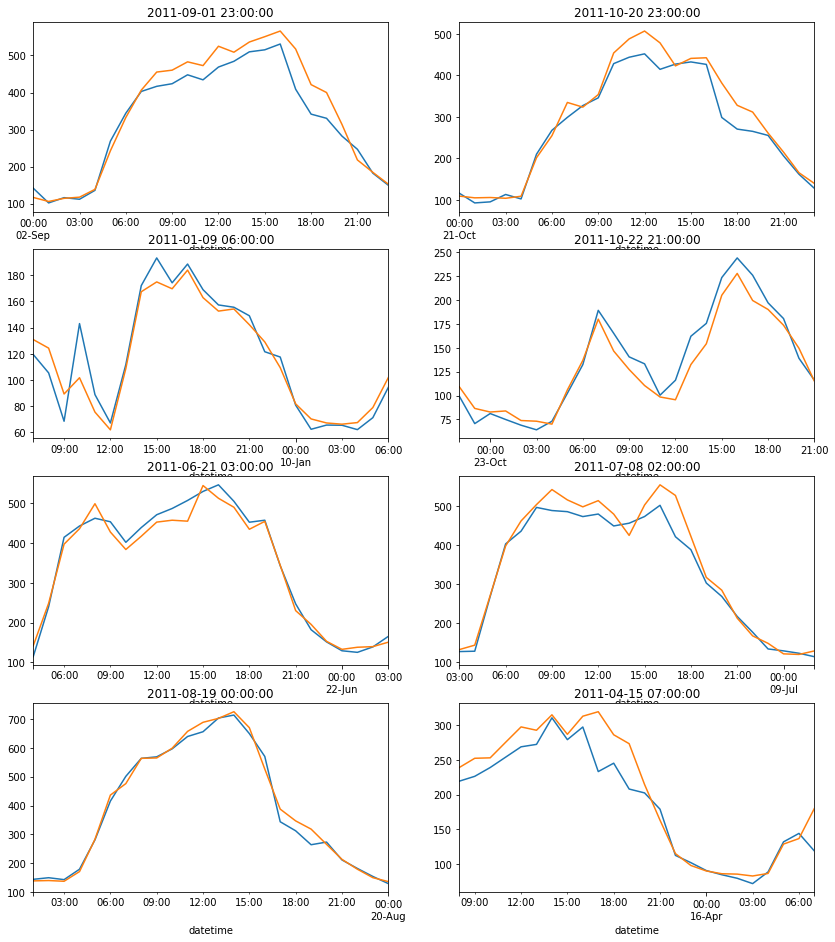

In [6]:
pred_indices = [32135, 33311, 26478, 33357, 30387, 30794, 31800, 28783]

mae_list = []
mse_list = []
r2_list = []
forecasts = pd.DataFrame(columns=['prediction','run_id','id'])

fig, ax = plt.subplots(4,2,figsize=(14,16))
i = 1
for index in pred_indices:
    
    pred_df = predict_components_and_sum_up(index=index)
    y_test = pred_df["actual"]
    y_pred_test = pred_df["pred"]

    day = index2datetime(index)
    #y_test = new_preds.loc[day+pd.DateOffset(hours=1):day+pd.DateOffset(hours=24), "actual"]
    #y_pred_test = new_preds.loc[day+pd.DateOffset(hours=1):day+pd.DateOffset(hours=24), "pred"]

    # Print error metrics
    mae = mean_absolute_error(y_test, y_pred_test)
    mse = mean_squared_error(y_test, y_pred_test)
    r2 = r2_score(y_test, y_pred_test)
    print(f"Day: {day}, mae: {mae:.3f}, mse: {mse:.3f}, rmse: {np.sqrt(mse):.3f}, r2: {r2:.3f}")
    mae_list.append(mae)
    mse_list.append(mse)
    r2_list.append(r2)
    # Plot actual vs predicted net energy usage for each of the chosen days
    plt.subplot(4, 2, i)
    y_test.plot()
    y_pred_test.plot()
    plt.title(day)
    i = i + 1

#    if write_data:
#        # Starting the MLFlow run
#        r = mlflow.start_run(run_name="random_forest")
#        print("run-uuid:", r.info.run_uuid)
#        for k, v in global_params.items():
#            mlflow.log_param(k, v)
#            mlflow.log_param("model", "random_forest")
#            mlflow.log_param("datetime", day)
#            mlflow.log_param("feature", "net_load_kW")
#            mlflow.log_metric("mse", mse)
#            mlflow.log_metric("mae", mae)
#            mlflow.log_metric("r2_score", r2)
#        mlflow.end_run()
#
#        # DataFrame for writing to SQL database
#        day_forecast = pd.DataFrame(columns=['prediction','run_id','id'])
#        day_forecast['prediction'] = y_pred_test
#        day_forecast['run_id'] = r.info.run_uuid
#        day_forecast['id'] = np.arange(index+1,index+25)
#        forecasts = pd.concat([forecasts, day_forecast], axis=0)
#
## Write to SQL DB
#if write_data:
#    forecasts = forecasts.set_index('id')
#    forecasts.to_sql("forecast", con=db, if_exists="append")

print(f"Avg mae: {np.mean(mae_list):.3f}, Avg mse: {np.mean(mse_list):.3f}, Avg rmse: {np.sqrt(np.mean(mse_list)):.3f}, Avg r2: {np.mean(r2):.3f}")

# only total net

----------------------------------------
Random Forest Regressor
----------------------------------------
R2 (train): 0.997
R2 (test) : 0.919
MAE (test): 28.402
MSE (test): 1966.354
RMSE(test): 44.344


28.40237531392694

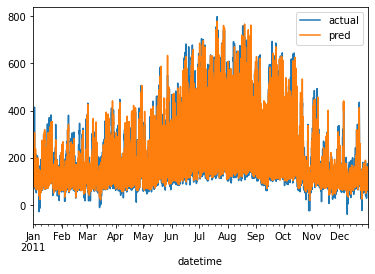

In [7]:
#directly predict net usage:
input_df = pd.concat([total_net, external_features], axis=1).rename(columns={'net_load_kW': 'target'})

#now we can start predicting
net_prediction = predict_target_col(input_df)
net_pred_df = pd.DataFrame({
    'pred': net_prediction,
    'datetime': pd.date_range('2011-01-01', '2011-12-31 23:00', freq='H'),
}).set_index('datetime')

net_pred_df["actual"] = total_net

net_pred_df[["actual", "pred"]].plot()
mean_absolute_error(net_pred_df["pred"], net_pred_df["actual"])

# using component predictions as additional inputs
- for this I have to predict in the train years as well, where the error may be different.